In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import datetime
from matplotlib.ticker import ScalarFormatter
from pylab import rcParams

In [2]:
url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=1277942400&to=1640995200"
data = requests.get(url).json()
df = pd.DataFrame.from_dict(data, orient='index').transpose()

# Problema: Verificar o index do dado errado para possível correção mais para a frente

Existe um dados por volta de 2017 na coluna de "Market Cap" que está alterado com o dado do dia seguinte por nao existir qualquer dado para aquele dia em relação ao "market cap".
Para contornar este problema decidimos encontrar o index do dia em que se encontra o erro nos dados e substituir por 0.

In [3]:
#Verificar o index do dado errado para possível correção mais para a frente
def Worng_value_check(prices, marketcaps):
    for i in range(len(prices)):
        price = prices[i]
        marketcap = marketcaps[i]
        if price[0] != marketcap[0]:
            return(i)
            break
            
print("O dado com problemas está situado no index:", Worng_value_check(df["prices"], df["market_caps"]))

O dado com problemas está situado no index: 603


Como a data "1491091200000" se encontra no dia 2 de Abril de 2017, não causará nenhum problema nos cálculos nem gráficos apresentados neste trabalho. Com isto, ao substituir por 0 no dataframe "limpo" e colocar os restantes dados nas posições corretas, foi possível usar estes dados para o nosso objetivo sem problema algum.

In [4]:
def limpeza_dados_preco(prices, marketcaps, volumes):
    
    # Novas variáveis globais para limpeza dos dados e cração de um novo dataframe
    # A conversão para uma variável "global" serve para essa variável se tornar "pública" e poder ser usada fora da função
    global cleanprices, cleanmarketcap, cleanvolume, cleandate
    cleanprices = []
    cleanmarketcap = []
    cleanvolume = []
    cleandate = []
    
    #Loop para limpeza dos dados
    for i in range(len(prices)):
        #if statement para corrigir o erro do dado incorreto, substituindo o dado incorreto por 0 e usando os dados anteriores para as datas seguintes
        if i < 457:
            marketcap = marketcaps[i]
        elif i > 457:
            marketcap = marketcaps[i-1]
        elif i == 457:
            marketcap = [0, 0]
        price = prices[i]
        volume = volumes[i]
        epoch_time = price [0]
        
        #Adicionar integers de preço, volume e marketcap sem integers de tempo epoch a mais
        cleanmarketcap.append(marketcap[1])
        cleanvolume.append(volume[1])
        cleanprices.append(price[1])
        cleandate.append(epoch_time/1000)

#Criação de dicionairio "ethusd" para o data frame usando os dados limpos, mais organizados e corretos
limpeza_dados_preco(df["prices"], df["market_caps"], df["total_volumes"])
ethusd = {"Data":cleandate, 
          "ETHUSD":cleanprices,
          "MarketCap":cleanmarketcap, 
          "Volume":cleanvolume}

#Criação da nova dataframe.
df_eth_prices = pd.DataFrame(data=ethusd)

#Começar index com 1 indicando o dia
df_eth_prices.index += 1

#Converter tempo epoch em tempo ISO 8601 para ser percetível a qualquer humano ler a data
df_eth_prices["Data"] = pd.to_datetime(df_eth_prices["Data"], unit="s")
df_eth_prices
#Dado em falta: nao existe dado de Marketcap para o dia 02 de Abril de 2017, ficando assim em 0, no dia/index 458 (df_eth_prices.loc[458])

,Data,ETHUSD,MarketCap,Volume
1,2015-08-07,2.831620,0.000000e+00,9.062200e+04
2,2015-08-08,1.330750,8.033948e+07,3.680700e+05
3,2015-08-10,0.687586,4.155631e+07,4.004641e+05
4,2015-08-11,1.067379,6.453901e+07,1.518998e+06
5,2015-08-12,1.256613,7.601326e+07,2.073893e+06
...,...,...,...,...
2117,2021-05-24,2120.037375,2.440703e+11,7.783986e+10
2118,2021-05-25,2640.159632,3.060461e+11,7.349606e+10
2119,2021-05-26,2695.477807,3.125662e+11,9.246870e+10
2120,2021-05-27,2882.483408,3.344351e+11,5.311522e+10


In [6]:
df_eth_prices.to_csv("ethereum_price_marketcap_volume_20150807_20210528.csv", index=False)

# Gráfico de preço hitórico entre 2016 e 2021

Criação de gráfico de preço e volume, um em cima do outro usando "subplot array" para separar os dois gráficos. Para melhor interpretação dos gráficos foi escolhido um simples gráfico de linhas para a representação do preço e um gráfico de barras para a representação do volume de compra e venda da moeda virtual denominada por "ethereum".

In [6]:
%matplotlib notebook
fig, axarr = plt.subplots(2, sharex=True)

axarr[0].set_title("ETH/USD")
axarr[0].plot(df_eth_prices["Data"], 
              df_eth_prices["ETHUSD"], 
              label = "ETH/USD", 
              linewidth = "2",
              color = "r")

axarr[1].set_title("Volume em Mil Milhões USD (10^9)")
axarr[1].bar(df_eth_prices["Data"], 
             df_eth_prices["Volume"]/1000000000, 
             color = "g",
             label = "MarketCap")

# rcParams neste caso serve para controlar o tamanho da imagem renderizada e do texto
rcParams['figure.figsize'] = 9.9, 6.5
rcParams['font.size'] = 12
rcParams['figure.dpi'] = 100

# ticklabel_format foi necessário para apresentar o eixo y de volume em notação normal, pois em autmoático apresentava 
# sempre em notação científica 
plt.xlabel("Days")

# set_yscale("log") para usar escala logarítmica na atuação do preço
axarr[0].set_yscale("log")
axarr[0].set_yticks([1, 10, 100, 1000, 10000])

# as três linhas de código abaixo foram necessárias para não usar notação cientifica nas labels do gráfico de preço
axarr[0].get_yaxis().set_major_formatter(ScalarFormatter())
axarr[0].ticklabel_format(axis="y", style='plain')
plt.ticklabel_format(axis="y", style='plain')

axarr[0].grid()
plt.grid()

<IPython.core.display.Javascript object>

# Calculo de ROI anual

De modo a fazer o cálculo de "Return on Investment" tivemos que obter, da base de dados inicial, os dados necessários para os cáclculos de ROI de 30, 60, 90 dias e anual. Para isso algumas listas de controlo foram criadas como, "iniciais_anuais", "preços_anuais" e "iniciais".  

A forma de cálculo do ROI é simples, após obter os dados corretos, usando a seguinte fórmula: (Receita - Custo)/Custo*100. O ROI calculado nao tem em conta taxas que possam ser aplicadas pela Casa de Câmbio usada

In [10]:
# Lista de controlo para obter os preços do dia 1 de cada ano
iniciais_anuais = ['2021-01-01 00:00:00', 
                   '2020-01-01 00:00:00', 
                   '2019-01-01 00:00:00', 
                   '2018-01-01 00:00:00',
                   '2017-01-01 00:00:00', 
                   '2016-01-01 00:00:00']

# Lista para uso no gráfico como eixo horizontal
anos = [2016, 2017, 2018, 2019, 2020]

# Lista vazia para obter os preços do dia 1 de cada ano
preços_anuais = []

# Loop for para obter os preços do dia 1 de cada ano
for i in range(len(df_eth_prices)):
    if str(df_eth_prices.loc[i+1]["Data"]) in iniciais_anuais:
        preços_anuais.append(df_eth_prices.loc[i+1]["ETHUSD"])

# Cálculo de ROI em cada ano, utilizando o preço inicial do ano em que comprou e o preço do ano seguinte
roi_anual = []
for i in range(len(preços_anuais)):
    # If statement para parar o loop e nao tentar calcular o ROI do ano 2021, daría erro por nao haver ainda preço 
    # do dia 01-01-2022
    if i+1 > len(preços_anuais)-1:
        break
    roi = (preços_anuais[i+1]-preços_anuais[i])/preços_anuais[i]*100
    roi_anual.append(roi)
    
# Eliminar peço 2021 para colocar no dataframe
preços_anuais.pop()

# Criação de Dataframe
ROI_anual_dict = {"Ano":anos, "ROI":roi_anual, "Preço Inicial":preços_anuais}

# Criação dataframe limpa.
ROI_anual = pd.DataFrame(data=ROI_anual_dict)

# Começar index com 1 indicando o dia
ROI_anual.index += 1

# Média Anual para criação de linha horizontal com o ROI médio durante a amostra dos 7 anos
média_roi_anual = ROI_anual["ROI"].mean()
ROI_anual

,Ano,ROI,Preço Inicial
1,2016,752.232514,0.946313
2,2017,9523.069310,8.064790
3,2018,-83.061196,776.080330
4,2019,-1.728557,131.458725
5,2020,471.745185,129.186385


In [27]:
ROI_anual.to_csv("ethereum_roi_anual_2016-2020.csv", index=False)

# Representação gráfica de ROI Anual

<IPython.core.display.Javascript object>


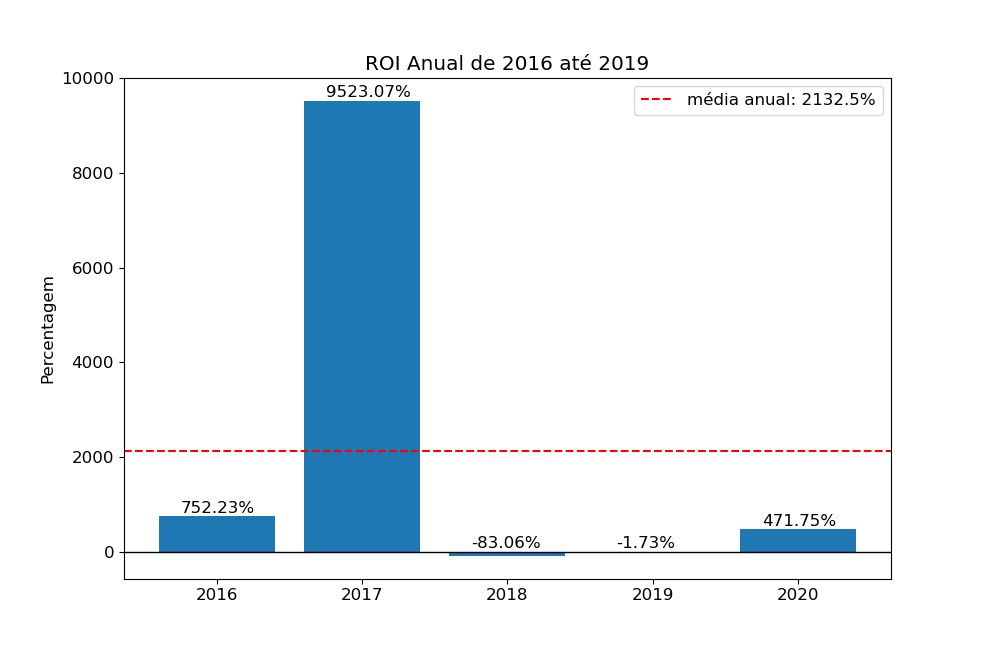

In [19]:
fig, ax = plt.subplots()

ax.bar(ROI_anual["Ano"], ROI_anual["ROI"])

# Criação da linha horizontal de média
plt.axhline(y = média_roi_anual, color = 'r', linestyle = 'dashed', label = "média anual: "+str(round(média_roi_anual, 1))+"%")  

plt.legend()
plt.axhline(y = 0, color = 'black', linewidth=1) 
plt.ylabel('Percentagem')

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(ROI_anual["ROI"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(ROI_anual["Ano"][i+1]-0.25, v+75, str(round(ROI_anual["ROI"][i+1],2))+'%', fontsize=12)

plt.title('ROI Anual de 2016 até 2019')
plt.show()

# Cálculo de ROI de 30, 60 e 90 Dias.

In [20]:
# Lista de controlo para obter os preços do dia 1 de cada mês, dividido por "nested lists" por ano
iniciais = [
    ['2020-01-01 00:00:00','2020-02-01 00:00:00','2020-03-01 00:00:00','2020-04-01 00:00:00','2020-05-01 00:00:00','2020-06-01 00:00:00','2020-07-01 00:00:00','2020-08-01 00:00:00','2020-09-01 00:00:00','2020-10-01 00:00:00','2020-11-01 00:00:00','2020-12-01 00:00:00'], 
    ['2019-01-01 00:00:00','2019-02-01 00:00:00','2019-03-01 00:00:00','2019-04-01 00:00:00','2019-05-01 00:00:00','2019-06-01 00:00:00','2019-07-01 00:00:00','2019-08-01 00:00:00','2019-09-01 00:00:00','2019-10-01 00:00:00','2019-11-01 00:00:00','2019-12-01 00:00:00'],
    ['2018-01-01 00:00:00','2018-02-01 00:00:00','2018-03-01 00:00:00','2018-04-01 00:00:00','2018-05-01 00:00:00','2018-06-01 00:00:00','2018-07-01 00:00:00','2018-08-01 00:00:00','2018-09-01 00:00:00','2018-10-01 00:00:00','2018-11-01 00:00:00','2018-12-01 00:00:00'],
    ['2017-01-01 00:00:00','2017-02-01 00:00:00','2017-03-01 00:00:00','2017-04-01 00:00:00','2017-05-01 00:00:00','2017-06-01 00:00:00','2017-07-01 00:00:00','2017-08-01 00:00:00','2017-09-01 00:00:00','2017-10-01 00:00:00','2017-11-01 00:00:00','2017-12-01 00:00:00'],
    ['2016-01-01 00:00:00','2016-02-01 00:00:00','2016-03-01 00:00:00','2016-04-01 00:00:00','2016-05-01 00:00:00','2016-06-01 00:00:00','2016-07-01 00:00:00','2016-08-01 00:00:00','2016-09-01 00:00:00','2016-10-01 00:00:00','2016-11-01 00:00:00','2016-12-01 00:00:00'],
]

# Lista de meses para uso gráfico
meses = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]

# Função para o cálculo de ROI, com quantidade de dias variável, mensal.
def ROIcalculator(dias, df_eth_prices, ano):
    
    # Novas variáveis globais para limpeza dos dados e cração de um novo dataframe
    # A conversão para uma variável "global" serve para essa variável se tornar "pública" e poder ser usada fora da função
    global roixdias
    
    # Lista de resultador final para o ROI
    roixdias = []
    for i in range(1, len(df_eth_prices)):
        
        # If statements para seleção da lista controlo de acordo com o ano escolhido
        if ano == 2020:
            inicial_de_cada_mes = iniciais[0]
        if ano == 2019:
            inicial_de_cada_mes = iniciais[1]
        if ano == 2018:
            inicial_de_cada_mes = iniciais[2]
        if ano == 2017:
            inicial_de_cada_mes = iniciais[3]
        if ano == 2016:
            inicial_de_cada_mes = iniciais[4]
            
        # If statement para uso da lista controlo
        if str(df_eth_prices.loc[i]["Data"]) in inicial_de_cada_mes:
            
            # Fórmula para o cálculo de ROI
            roi = (df_eth_prices.loc[i+dias]["ETHUSD"]-df_eth_prices.loc[i]["ETHUSD"])/df_eth_prices.loc[i]["ETHUSD"]*100
            roixdias.append(roi)

In [22]:
# Criação de Dataframes para ROI 30, 60 e 90 dias
roi90mensal = pd.DataFrame(data=meses, columns=["Meses"])
roi60mensal = pd.DataFrame(data=meses, columns=["Meses"])
roi30mensal = pd.DataFrame(data=meses, columns=["Meses"])
roi90mensal.index += 1
roi60mensal.index += 1
roi30mensal.index += 1

# Loop para criação de colunas nos dataframes de acordo com o ano
for i in range(2016, 2021):
    # Loop para criação de colunas nos dataframes de acordo com o numero de dias de ROI
    for dias in [30, 60, 90]:
        # Uso da função anterior para o cáculo de ROI
        ROIcalculator(dias, df_eth_prices, i)
        # If statements para controlar em que dataframes são criadas as colunas (roi30mensal, roi60mensal ou roi90mensal)
        if dias == 30:
            roi30mensal["ROI "+str(dias)+" Dias "+str(i)] = roixdias
        elif dias == 60:
            roi60mensal["ROI "+str(dias)+" Dias "+str(i)] = roixdias
        elif dias == 90:
            roi90mensal["ROI "+str(dias)+" Dias "+str(i)] = roixdias

# ROI 90 dias médio durante 2020, 2019, 2018, 2017, 2016
roi90mensal["ROI 90 Dias Médio"] = (roi90mensal["ROI 90 Dias 2020"] + 
                                    roi90mensal["ROI 90 Dias 2019"] + 
                                    roi90mensal["ROI 90 Dias 2018"] + 
                                    roi90mensal["ROI 90 Dias 2017"] + 
                                    roi90mensal["ROI 90 Dias 2016"] )/5

# ROI 60 dias médio durante 2020, 2019, 2018, 2017, 2016
roi60mensal["ROI 60 Dias Médio"] = (roi60mensal["ROI 60 Dias 2020"] + 
                                    roi60mensal["ROI 60 Dias 2019"] + 
                                    roi60mensal["ROI 60 Dias 2018"] + 
                                    roi60mensal["ROI 60 Dias 2017"] + 
                                    roi60mensal["ROI 60 Dias 2016"] )/5

# ROI 30 dias médio durante 2020, 2019, 2018, 2017, 2016
roi30mensal["ROI 30 Dias Médio"] = (roi30mensal["ROI 30 Dias 2020"] + 
                                    roi30mensal["ROI 30 Dias 2019"] + 
                                    roi30mensal["ROI 30 Dias 2018"] + 
                                    roi30mensal["ROI 30 Dias 2017"] + 
                                    roi30mensal["ROI 30 Dias 2016"] )/5

roi90mensal

,Meses,ROI 90 Dias 2016,ROI 90 Dias 2017,ROI 90 Dias 2018,ROI 90 Dias 2019,ROI 90 Dias 2020,ROI 90 Dias Médio
1,Jan,1099.880634,525.258533,-49.000591,7.704064,2.459511,317.260430
2,Fev,297.521118,622.793387,-39.860516,49.986195,14.688966,189.025830
3,Mar,67.700631,1244.349790,-33.629046,98.379511,0.981372,275.556452
4,Abr,14.605916,464.574391,9.275183,127.022386,71.278782,137.351332
5,Mai,42.056571,156.615188,-29.621821,31.154263,54.478130,50.936466
6,Jun,-19.101403,70.810812,-49.537926,-37.044844,71.898945,7.405117
7,Jul,6.220868,9.767111,-50.553097,-40.554441,57.110316,-3.601849
8,Ago,1.988981,34.863791,-54.723869,-12.857018,11.688467,-3.807930
9,Set,-27.932664,17.553810,-58.293509,-10.354714,31.916530,-9.422109
10,Out,-38.553936,145.902883,-40.392886,-25.274940,104.558669,29.247958


In [31]:
roi90mensal.to_csv("ethereum_roi_90_dias_mensal_2016-2020.csv", index=False)

# Representação gráfica de ROI de 90 dias mensal médio

## Tamanho de amostras para o estudo: 
Foi usado dados diários a partir do dia 1 de Janeiro de 2016 até 1 de Janeiro de 2021

<IPython.core.display.Javascript object>


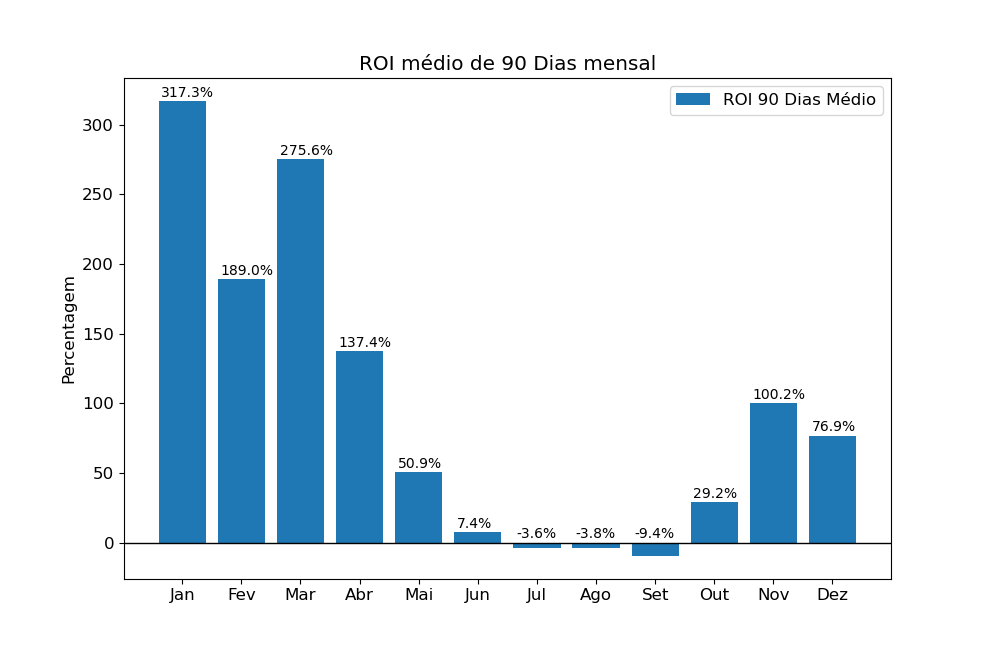

In [24]:
fig, ax = plt.subplots()

ax.bar(roi90mensal["Meses"], roi90mensal["ROI 90 Dias Médio"], label = "ROI 90 Dias Médio")   

plt.ylabel('Percentagem')
plt.axhline(y = 0, color = 'black', linewidth=1)
plt.legend()

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(roi90mensal["ROI 90 Dias Médio"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(i-0.355, v+3, str(round(roi90mensal["ROI 90 Dias Médio"][i+1],1))+'%', fontsize=10)

plt.title('ROI médio de 90 Dias mensal')
plt.show()

In [33]:
roi60mensal

,Meses,ROI 60 Dias 2016,ROI 60 Dias 2017,ROI 60 Dias 2018,ROI 60 Dias 2019,ROI 60 Dias 2020,ROI 60 Dias Médio
1,Jan,698.906314,135.512417,10.256470,2.659378,69.018087,183.270533
2,Fev,423.703160,352.093404,-65.725483,33.082456,-25.661378,143.498432
3,Mar,17.629436,364.832338,-19.642196,13.720204,-1.282439,75.051469
4,Abr,20.395216,358.836912,40.311831,80.368583,82.164697,116.415448
5,Mai,50.984383,270.468762,-34.738817,99.964798,11.018777,79.539580
6,Jun,-14.356605,-8.358218,-19.877699,-21.810555,44.079747,-4.064666
7,Jul,-9.073810,44.357327,-35.806392,-42.357665,77.033362,6.830564
8,Ago,20.298501,30.909016,-46.400877,-22.379086,3.879320,-2.738625
9,Set,-9.349215,-21.431973,-30.038188,6.427960,-12.116846,-13.301652
10,Out,-34.813363,51.551230,-49.435224,-14.186837,59.831130,2.589387


In [34]:
roi60mensal.to_csv("ethereum_roi_60_dias_mensal_2016-2020.csv", index=False)

# Representação gráfica de ROI de 60 dias mensal médio¶
## Tamanho de amostras para o estudo:
Foi usado dados diários a partir do dia 1 de Janeiro de 2016 até 1 de Janeiro de 2021

<IPython.core.display.Javascript object>


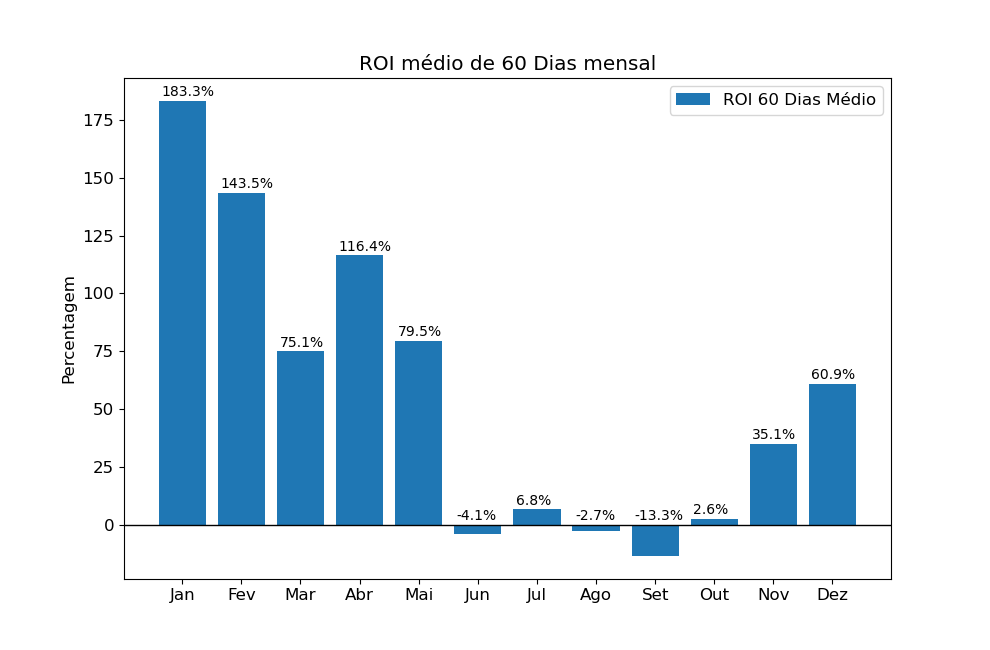

In [26]:
fig, ax = plt.subplots()

ax.bar(roi60mensal["Meses"], 
        roi60mensal["ROI 60 Dias Médio"], 
        label = "ROI 60 Dias Médio")


plt.ylabel('Percentagem')
plt.axhline(y = 0, color = 'black', linewidth=1)
plt.legend()

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(roi60mensal["ROI 60 Dias Médio"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(i-0.355, v+2, str(round(roi60mensal["ROI 60 Dias Médio"][i+1],1))+'%', fontsize=10)

plt.title('ROI médio de 60 Dias mensal')
plt.show()

In [36]:
roi30mensal

,Meses,ROI 30 Dias 2016,ROI 30 Dias 2017,ROI 30 Dias 2018,ROI 30 Dias 2019,ROI 30 Dias 2020,ROI 30 Dias Médio
1,Jan,142.918117,32.394000,36.338471,-17.637194,42.992017,47.401082
2,Fev,277.982006,83.027463,-23.116026,24.517973,22.156387,76.913561
3,Mar,50.190406,191.033206,-53.291291,5.018034,-39.379558,30.714159
4,Abr,-24.094192,52.394601,67.442849,13.531176,54.279111,32.710709
5,Mai,58.611335,201.084756,-16.203151,58.871413,18.074765,64.087823
6,Jun,-11.028278,18.325004,-21.390811,9.216873,-2.900254,-1.555493
7,Jul,-3.740882,-22.550789,1.924855,-28.409006,48.383237,-0.878517
8,Ago,4.815898,68.633739,-34.057408,-22.845017,23.783624,8.066167
9,Set,10.555383,-22.432956,-17.518686,4.465659,-17.465058,-8.479131
10,Out,-18.004188,1.290474,-15.178592,1.878417,6.479937,-4.706790


In [37]:
roi30mensal.to_csv("ethereum_roi_30_dias_mensal_2016-2020.csv", index=False)

# Representação gráfica de ROI de 30 dias mensal médio¶
## Tamanho de amostras para o estudo:
Foi usado dados diários a partir do dia 1 de Janeiro de 2016 até 1 de Janeiro de 2021

<IPython.core.display.Javascript object>


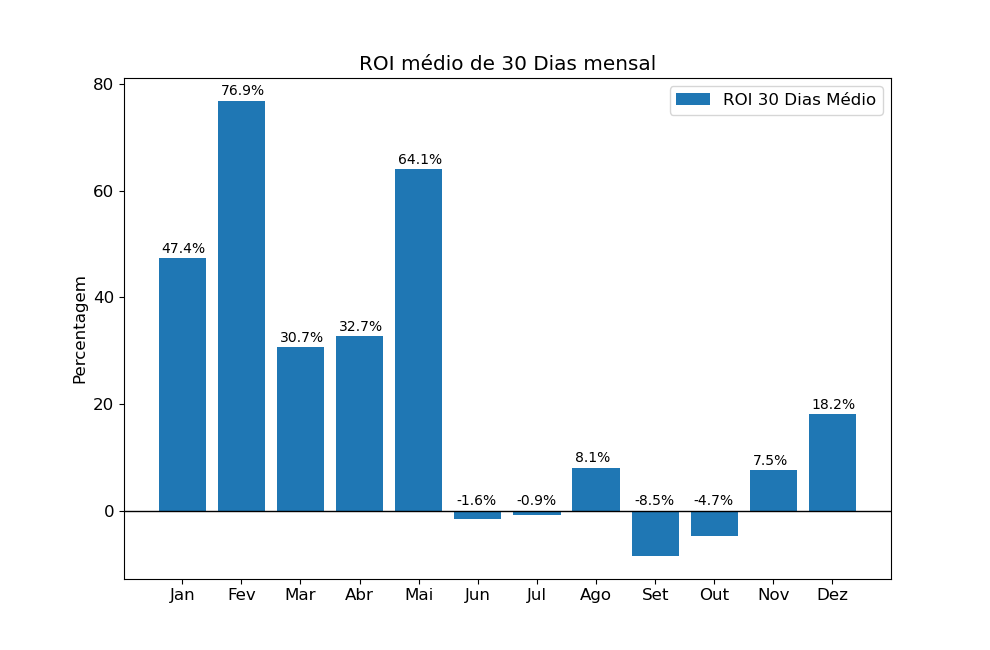

In [28]:
fig, ax = plt.subplots()

ax.bar(roi30mensal["Meses"], roi30mensal["ROI 30 Dias Médio"], label = "ROI 30 Dias Médio")


plt.ylabel('Percentagem')
plt.axhline(y = 0, color = 'black', linewidth=1)
plt.legend()

# Loop para obter o numero exato em percentagem de ROI anual em formato de texto colocado em cima de cada barra
for i, v in enumerate(roi30mensal["ROI 30 Dias Médio"]):
    # If statement para caso roi seja negativo para colocar o texto logo acima da linha y=0
    if v < 0:
        v = 0
    plt.text(i-0.355, v+1, str(round(roi30mensal["ROI 30 Dias Médio"][i+1],1))+'%', fontsize=10)

plt.title('ROI médio de 30 Dias mensal')
plt.show()